Set directory paths

In [1]:
from repath.utils.paths import project_root
import numpy as np

def show_np(arr_in):
    return Image.fromarray(np.array(arr_in, dtype=np.uint8))

image_dir = project_root() / 'data' / 'icaird_blood' / 'images'
annot_dir = project_root() / 'data' / 'icaird_blood' / 'annotations'

level_in = 6

Get list of files

Pick first file for testing

In [2]:
import os

image_list = os.listdir(image_dir)
annot_list = sorted(os.listdir(annot_dir))

In [3]:
image_list = sorted([im for im in image_list if im[-8:]=='.isyntax'])
test_im = image_list[0]
test_annot = annot_list[0]

Read in thumbnail of slide

In [4]:
from repath.data.slides.isyntax import Slide

thumbz = []

for tt in range(10):
    test_im = image_list[tt]
    with Slide(image_dir / test_im) as slide:
        thumb = slide.get_thumbnail(6)
        thumbz.append(thumb)

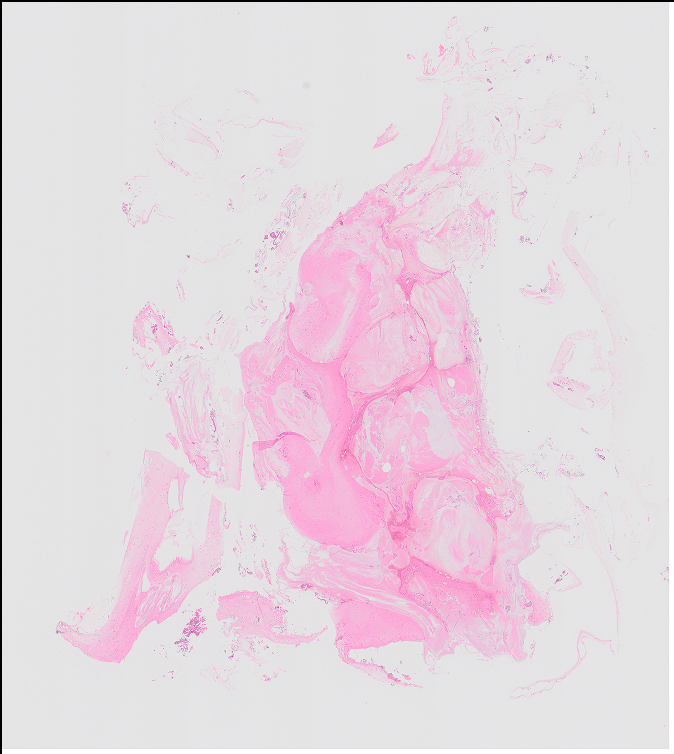

In [5]:
from PIL import Image
show_np(thumbz[9])

Read in annotations

In [6]:
from repath.data.annotations.geojson import load_annotations
from repath.data.annotations.annotation import AnnotationSet

group_labels = {"background": "background", "tissue": "tissue", "blood": "blood", "mucus": "mucus", "blood/mucus": "blood_mucus"}

default_label = "tissue"

annotz = []

for aa in range(10):
    print(aa)
    test_annot = annot_list[aa]
    annotations = load_annotations(annot_dir / test_annot, group_labels, default_label)
    grouplabels = {"background": 0, "tissue": 1, "blood": 2, "mucus": 3, "blood_mucus": 4}
    ann_set = AnnotationSet(annotations, grouplabels, ["background", "tissue", "blood", "mucus", "blood_mucus"], "background")
    ann_thumb = ann_set.render(thumbz[aa].shape, 2**6)
    annotz.append(ann_thumb[:,:,0])

0
1
2
3
4
5
6
7
8
9


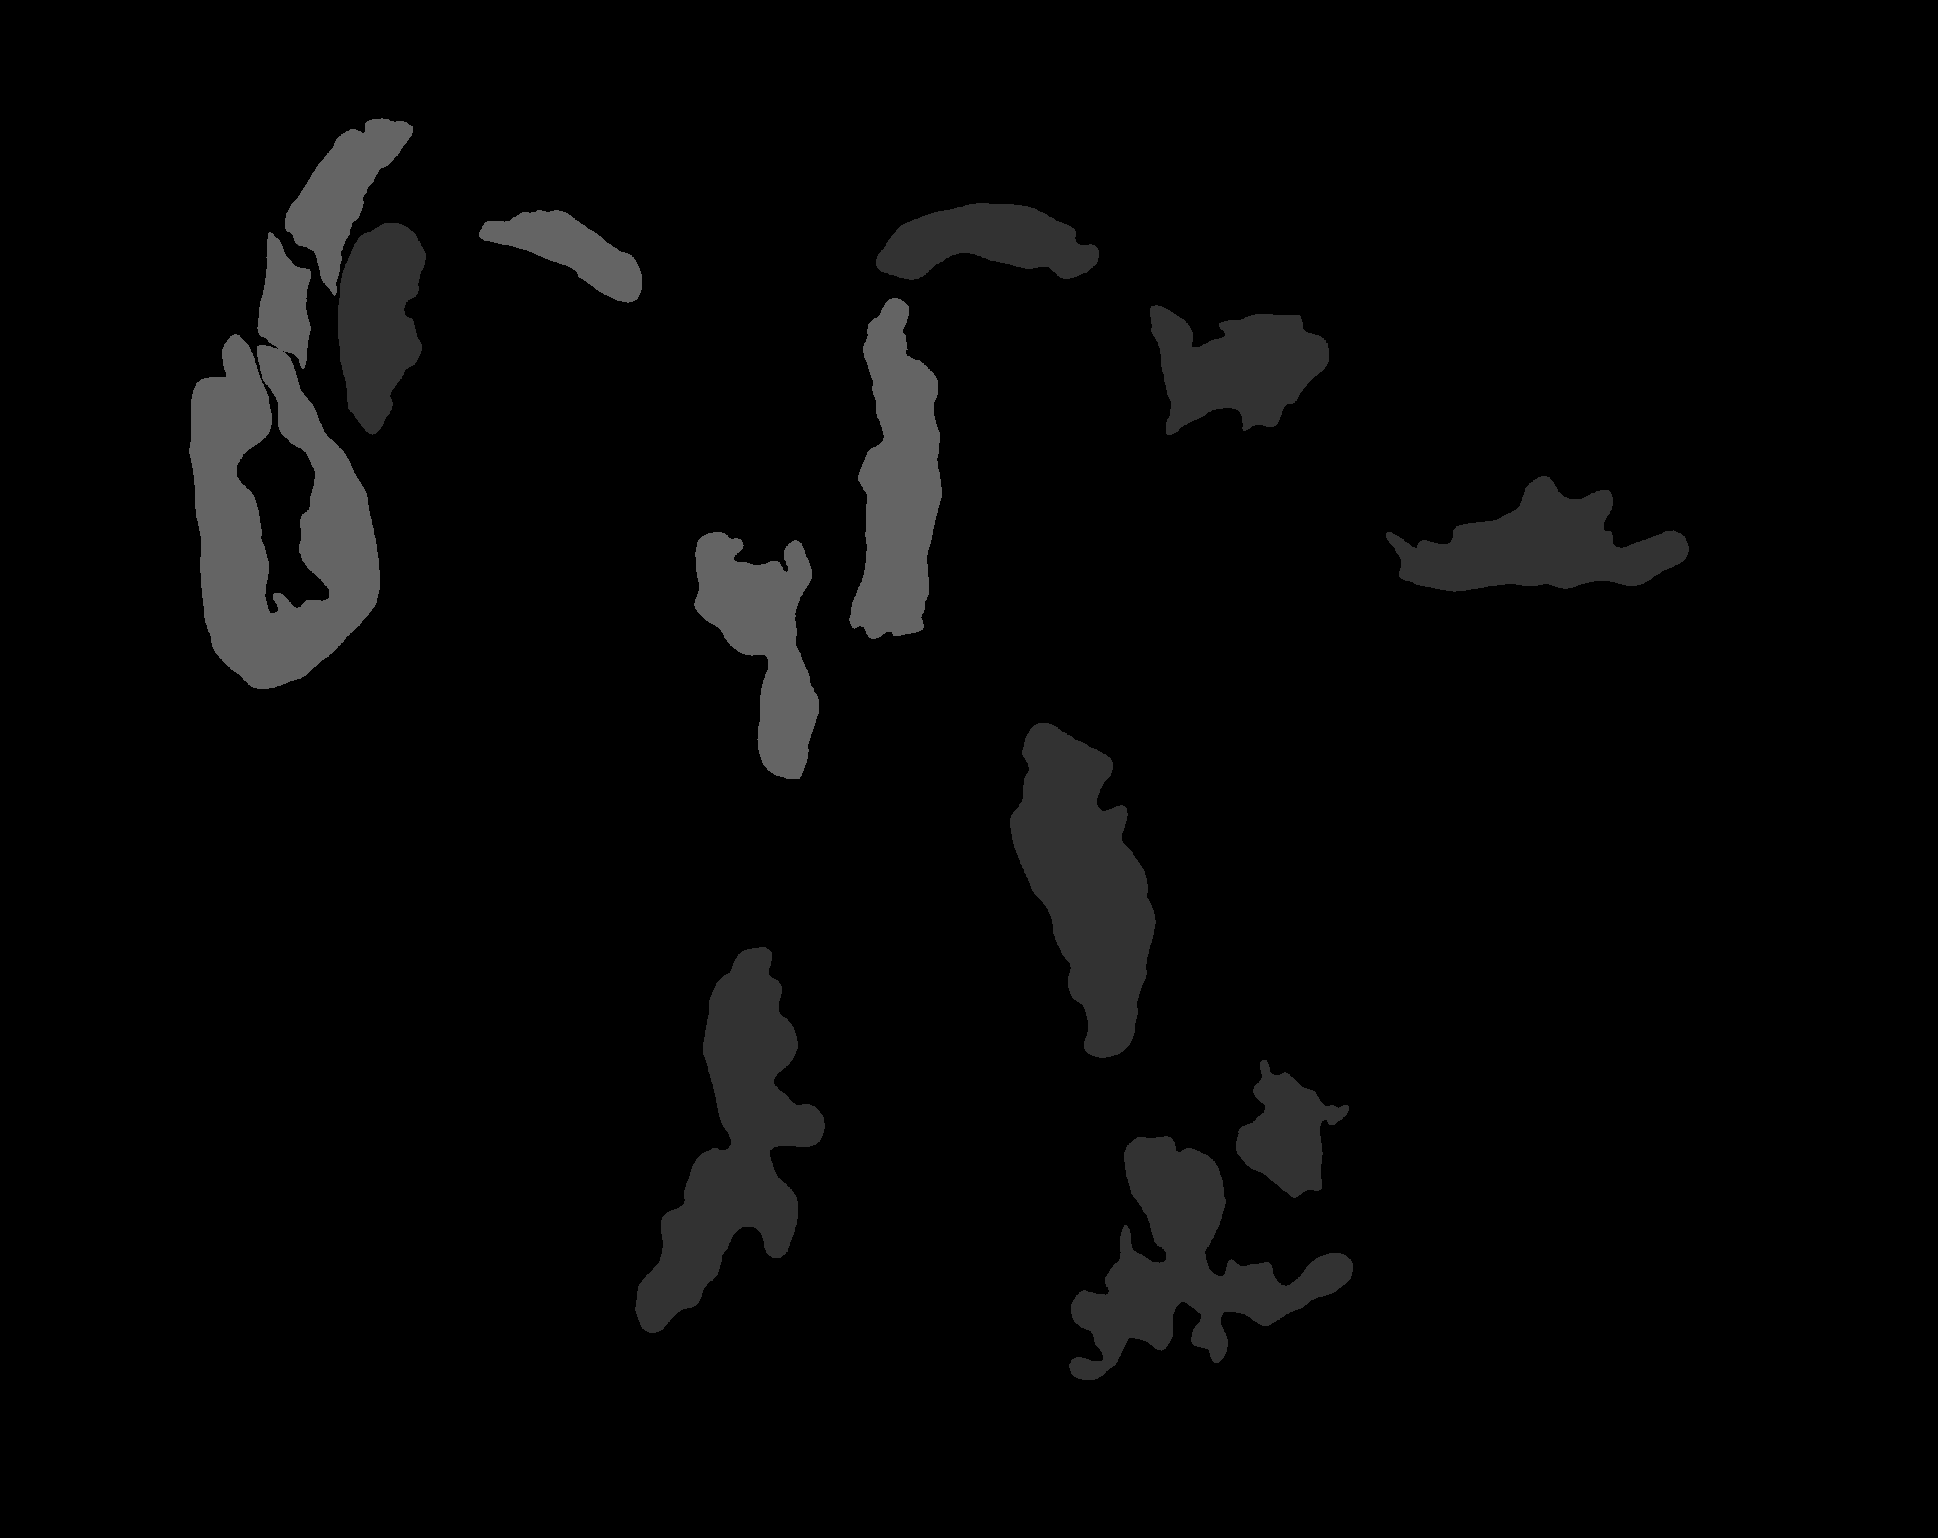

In [7]:
import numpy as np


show_np(annotz[5]*50)

Apply tissue segmentation

In [8]:
from repath.preprocess.tissue_detection import TissueDetectorGreyScale, SizedClosingTransform, FillHolesTransform

morphology_transform1 = SizedClosingTransform(level_in=level_in)
morphology_transform2 = FillHolesTransform(level_in=level_in)
morphology_transforms = [morphology_transform1, morphology_transform2]
tissue_detector = TissueDetectorGreyScale(grey_level=0.85, morph_transform = morphology_transforms)

In [9]:
filtered_thumbz = []
for tt in thumbz:
    tissue_mask = tissue_detector(tt)
    three_d_mask = np.expand_dims(tissue_mask, axis=-1)
    three_d_mask = np.dstack((three_d_mask, three_d_mask, three_d_mask))
    filtered_thumb = np.where(np.logical_not(three_d_mask), 255, tt)
    filtered_thumbz.append(filtered_thumb)
#show_np(tissue_mask*255)

Set background of thumbnail to white

In [10]:
three_d_mask = np.expand_dims(tissue_mask, axis=-1)
three_d_mask = np.dstack((three_d_mask, three_d_mask, three_d_mask))
filtered_thumb = np.where(np.logical_not(three_d_mask), 255, thumb)

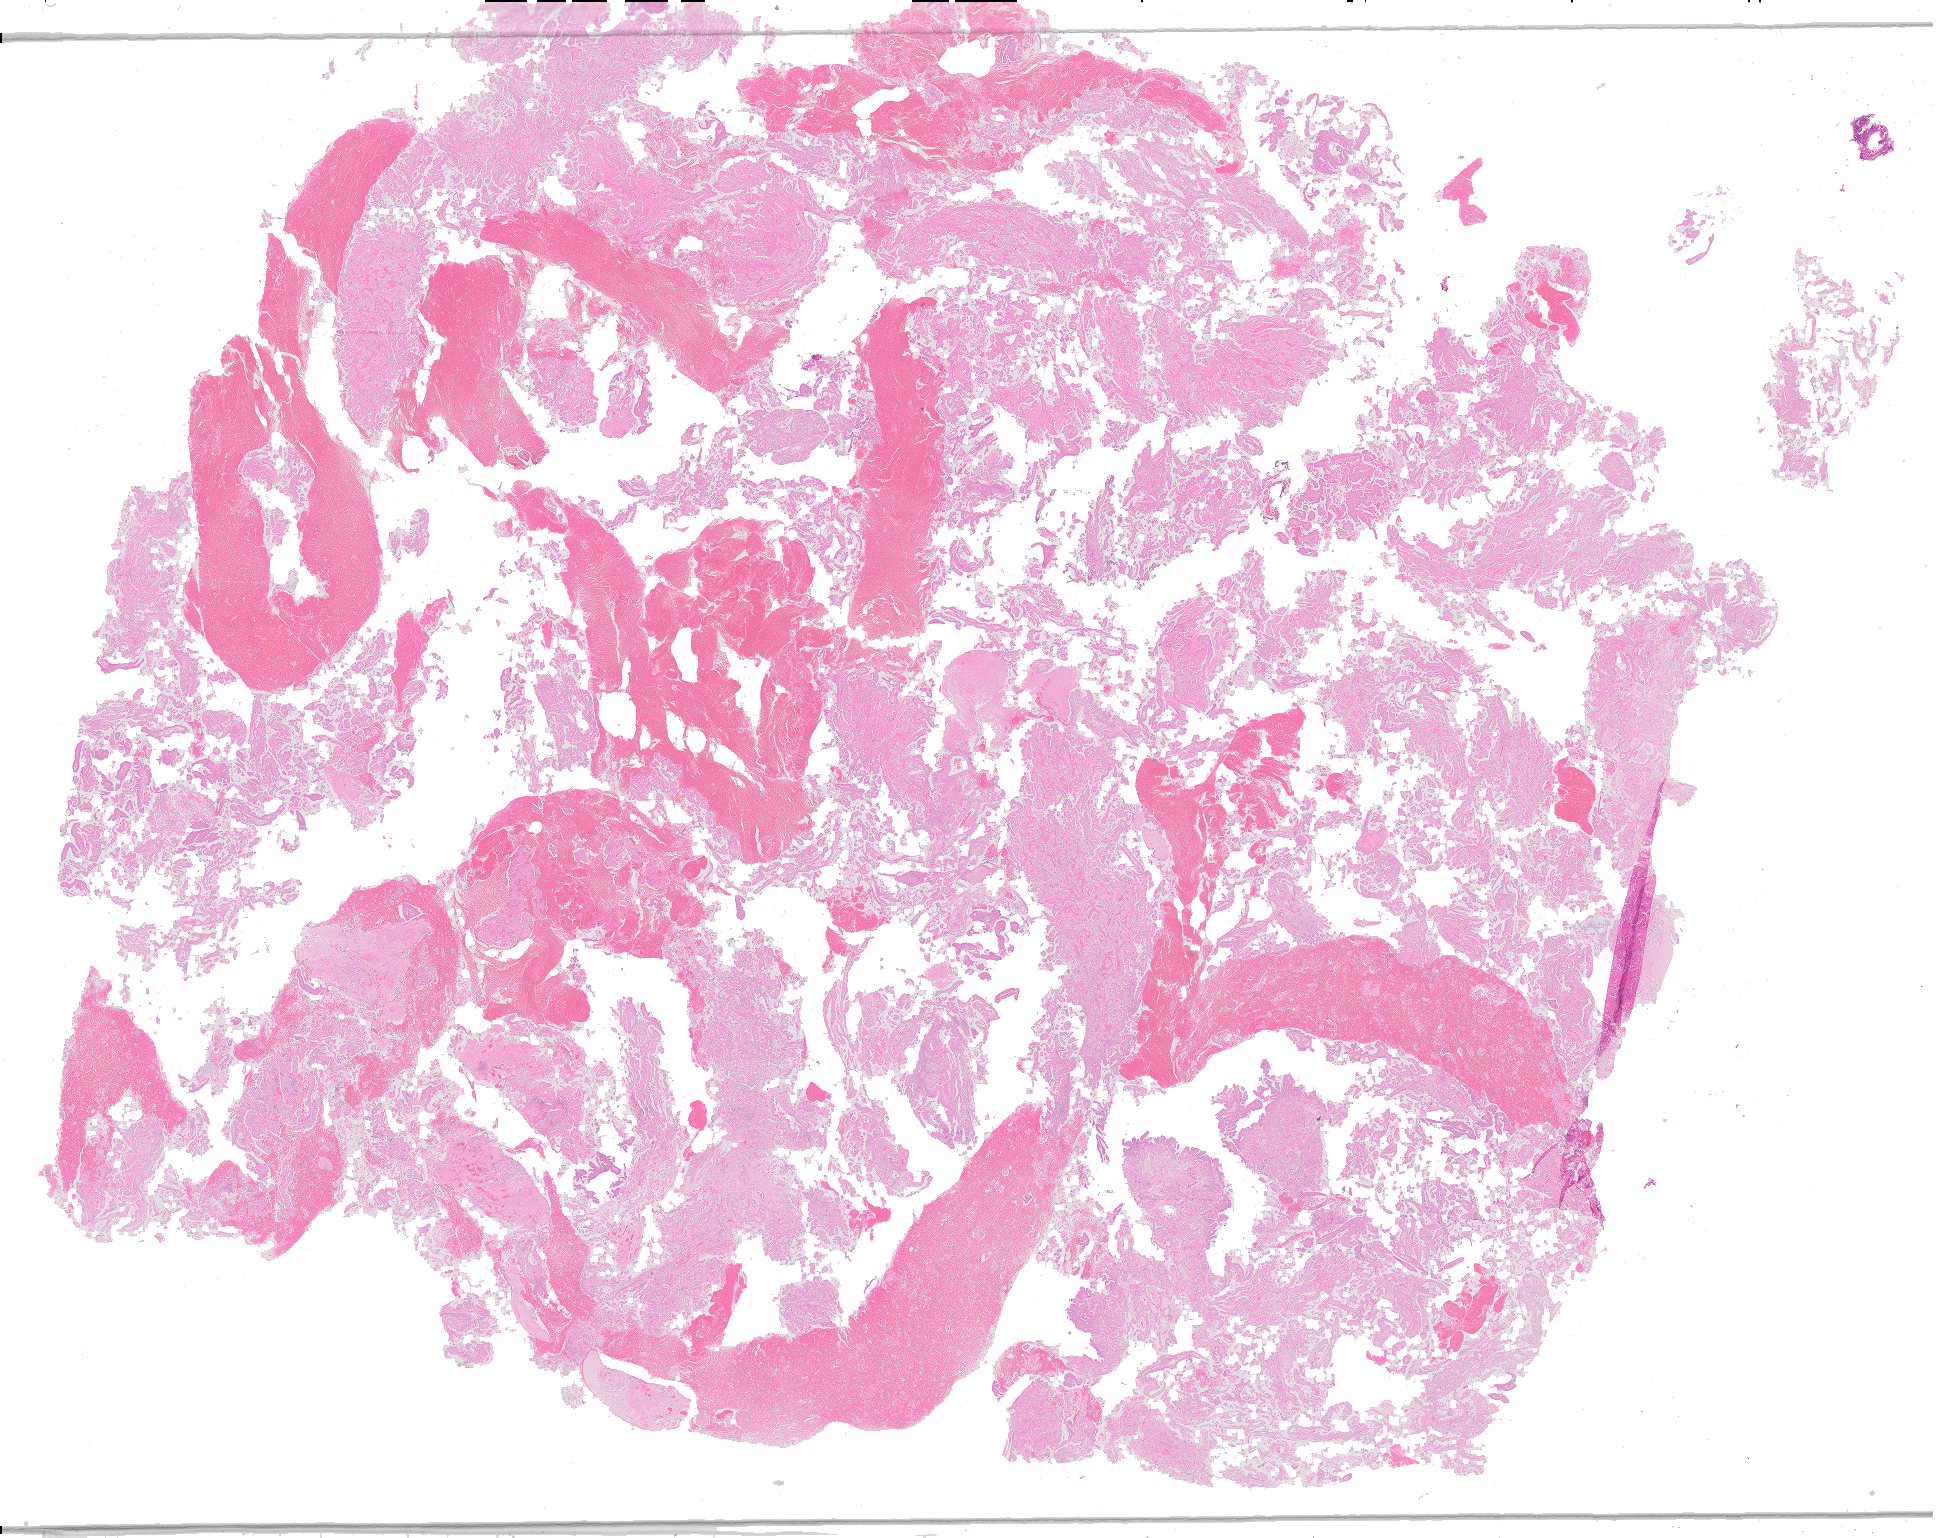

In [11]:
show_np(filtered_thumbz[5])

Segment image

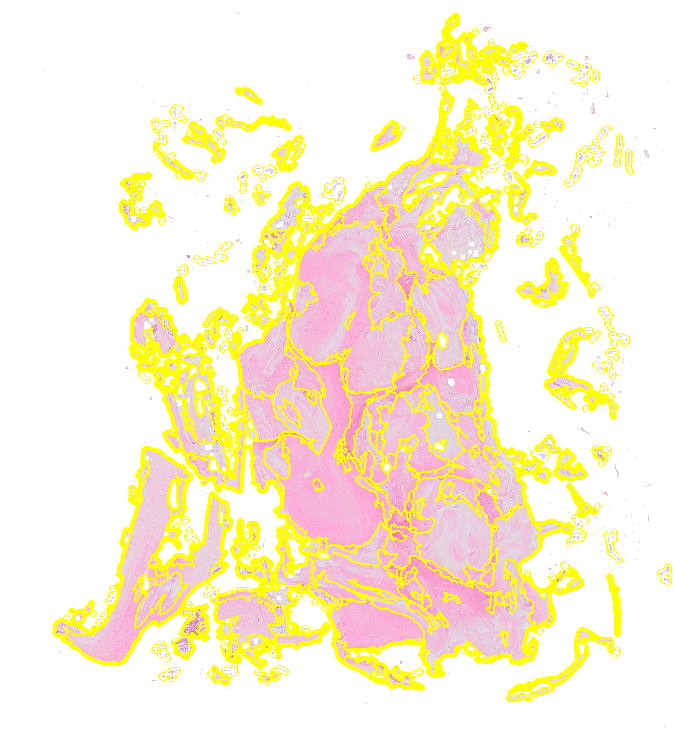

In [12]:
from skimage.segmentation import felzenszwalb
from skimage.segmentation import mark_boundaries

segments_fz = felzenszwalb(filtered_thumb, scale=100, sigma=0.5, min_size=50)
image_fz = mark_boundaries(filtered_thumb, segments_fz)

show_np(image_fz*255)

for each segment find area and labels in annotation

In [13]:
from skimage.measure import regionprops

regions = regionprops(segments_fz, ann_thumb[:, :, 0])

In [14]:
def get_region_class_counts(reg):

    # regions returns bounding boxes
    reg_mask = reg.image
    reg_intensity = reg.intensity_image
    reg_count = np.where(np.logical_not(reg_mask), -1, reg_intensity)
    reg0 = np.sum(reg_count == 0)
    reg1 = np.sum(reg_count == 1)
    reg2 = np.sum(reg_count == 2)
    reg3 = np.sum(reg_count == 3)
    reg4 = np.sum(reg_count == 4)
    
    out_list = [reg0, reg1, reg2, reg3, reg4]

    return out_list

In [15]:
region_class_counts = np.zeros((len(regions), 5))
for idx, reg in enumerate(regions):
    region_class_counts[idx, :] = get_region_class_counts(reg)
    
region_class_counts

array([[1580.,   31.,    0.,    0.,    0.],
       [ 106.,    0.,    0.,    0.,    0.],
       [  81.,    0.,    0.,    0.,    0.],
       ...,
       [  73.,    0.,    0.,    0.,    0.],
       [  89.,    0.,    0.,    0.,    0.],
       [ 178.,    0.,    0.,    0.,    0.]])

In [16]:
pct_region_class = np.divide(region_class_counts, np.sum(region_class_counts, axis=1, keepdims=True))
pct_region_class

array([[0.98075729, 0.01924271, 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ],
       ...,
       [1.        , 0.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ]])

In [17]:
tissue_seg_mask = pct_region_class[:, 1] > 0.9
blood_seg_mask = pct_region_class[:, 2] > 0.9
mucus_seg_mask = pct_region_class[:, 3] > 0.9
blood_mucus_seg_mask = pct_region_class[:, 4] > 0.9

In [18]:
print(np.sum(tissue_seg_mask), np.sum(blood_seg_mask), np.sum(mucus_seg_mask), np.sum(blood_mucus_seg_mask))

0 0 0 133


In [19]:
one_hot = np.hstack((np.expand_dims(tissue_seg_mask, axis=-1), np.expand_dims(blood_seg_mask, axis=-1), np.expand_dims(mucus_seg_mask, axis=-1), np.expand_dims(blood_mucus_seg_mask, axis=-1)))

In [20]:
one_hot_sum = np.expand_dims(np.less(np.sum(one_hot, axis=1), 1), axis=-1)
one_hot = np.hstack((one_hot_sum, one_hot))

In [21]:
seg_labels = np.argmax(one_hot, axis=1)

get features of segments

In [22]:
# multiscale basic features not in the version we have of scikit so copying in from github source

from itertools import combinations_with_replacement
import itertools
import numpy as np
from skimage import filters, feature
from skimage import img_as_float32
from concurrent.futures import ThreadPoolExecutor


def _texture_filter(gaussian_filtered):
    H_elems = [
        np.gradient(np.gradient(gaussian_filtered)[ax0], axis=ax1)
        for ax0, ax1 in combinations_with_replacement(range(gaussian_filtered.ndim), 2)
    ]
    eigvals = feature.hessian_matrix_eigvals(H_elems)
    return eigvals


def _singlescale_basic_features_singlechannel(
    img, sigma, intensity=True, edges=True, texture=True
):
    results = ()
    gaussian_filtered = filters.gaussian(img, sigma)
    if intensity:
        results += (gaussian_filtered,)
    if edges:
        results += (filters.sobel(gaussian_filtered),)
    if texture:
        results += (*_texture_filter(gaussian_filtered),)
    return results


def _mutiscale_basic_features_singlechannel(
    img,
    intensity=True,
    edges=True,
    texture=True,
    sigma_min=0.5,
    sigma_max=16,
    num_sigma=None,
    num_workers=None,
):
    """Features for a single channel nd image.
    Parameters
    ----------
    img : ndarray
        Input image, which can be grayscale or multichannel.
    intensity : bool, default True
        If True, pixel intensities averaged over the different scales
        are added to the feature set.
    edges : bool, default True
        If True, intensities of local gradients averaged over the different
        scales are added to the feature set.
    texture : bool, default True
        If True, eigenvalues of the Hessian matrix after Gaussian blurring
        at different scales are added to the feature set.
    sigma_min : float, optional
        Smallest value of the Gaussian kernel used to average local
        neighbourhoods before extracting features.
    sigma_max : float, optional
        Largest value of the Gaussian kernel used to average local
        neighbourhoods before extracting features.
    num_sigma : int, optional
        Number of values of the Gaussian kernel between sigma_min and sigma_max.
        If None, sigma_min multiplied by powers of 2 are used.
    num_workers : int or None, optional
        The number of parallel threads to use. If set to ``None``, the full
        set of available cores are used.
    Returns
    -------
    features : list
        List of features, each element of the list is an array of shape as img.
    """
    # computations are faster as float32
    img = np.ascontiguousarray(img_as_float32(img))
    if num_sigma is None:
        num_sigma = int(np.log2(sigma_max) - np.log2(sigma_min) + 1)
    sigmas = np.logspace(
        np.log2(sigma_min),
        np.log2(sigma_max),
        num=num_sigma,
        base=2,
        endpoint=True,
    )
    with ThreadPoolExecutor(max_workers=num_workers) as ex:
        out_sigmas = list(
            ex.map(
                lambda s: _singlescale_basic_features_singlechannel(
                    img, s, intensity=intensity, edges=edges, texture=texture
                ),
                sigmas,
            )
        )
    features = itertools.chain.from_iterable(out_sigmas)
    return features


def multiscale_basic_features(
    image,
    multichannel=False,
    intensity=True,
    edges=True,
    texture=True,
    sigma_min=0.5,
    sigma_max=16,
    num_sigma=None,
    num_workers=None,
):
    """Local features for a single- or multi-channel nd image.
    Intensity, gradient intensity and local structure are computed at
    different scales thanks to Gaussian blurring.
    Parameters
    ----------
    image : ndarray
        Input image, which can be grayscale or multichannel.
    multichannel : bool, default False
        True if the last dimension corresponds to color channels.
    intensity : bool, default True
        If True, pixel intensities averaged over the different scales
        are added to the feature set.
    edges : bool, default True
        If True, intensities of local gradients averaged over the different
        scales are added to the feature set.
    texture : bool, default True
        If True, eigenvalues of the Hessian matrix after Gaussian blurring
        at different scales are added to the feature set.
    sigma_min : float, optional
        Smallest value of the Gaussian kernel used to average local
        neighbourhoods before extracting features.
    sigma_max : float, optional
        Largest value of the Gaussian kernel used to average local
        neighbourhoods before extracting features.
    num_sigma : int, optional
        Number of values of the Gaussian kernel between sigma_min and sigma_max.
        If None, sigma_min multiplied by powers of 2 are used.
    num_workers : int or None, optional
        The number of parallel threads to use. If set to ``None``, the full
        set of available cores are used.
    Returns
    -------
    features : np.ndarray
        Array of shape ``image.shape + (n_features,)``
    """
    if not any([intensity, edges, texture]):
        raise ValueError(
                "At least one of ``intensity``, ``edges`` or ``textures``"
                "must be True for features to be computed."
                )
    if image.ndim < 3:
        multichannel = False
    if not multichannel:
        image = image[..., np.newaxis]
    all_results = (
        _mutiscale_basic_features_singlechannel(
            image[..., dim],
            intensity=intensity,
            edges=edges,
            texture=texture,
            sigma_min=sigma_min,
            sigma_max=sigma_max,
            num_sigma=num_sigma,
            num_workers=num_workers,
        )
        for dim in range(image.shape[-1])
    )
    features = list(itertools.chain.from_iterable(all_results))
    return np.stack(features, axis=-1)

In [23]:
from functools import partial
sigma_min = 1
sigma_max = 16
features_func = partial(multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        multichannel=True)
features = features_func(thumb)

In [24]:
features.shape

(754, 674, 45)

In [25]:
# fit and predict segmenter also copied from scikit image v 18

def fit_segmenter(labels, features, clf):
    """Segmentation using labeled parts of the image and a classifier.
    Parameters
    ----------
    labels : ndarray of ints
        Image of labels. Labels >= 1 correspond to the training set and
        label 0 to unlabeled pixels to be segmented.
    features : ndarray
        Array of features, with the first dimension corresponding to the number
        of features, and the other dimensions correspond to ``labels.shape``.
    clf : classifier object
        classifier object, exposing a ``fit`` and a ``predict`` method as in
        scikit-learn's API, for example an instance of
        ``RandomForestClassifier`` or ``LogisticRegression`` classifier.
    Returns
    -------
    clf : classifier object
        classifier trained on ``labels``
    Raises
    ------
    NotFittedError if ``self.clf`` has not been fitted yet (use ``self.fit``).
    """
    mask = labels > 0
    training_data = features[mask]
    training_labels = labels[mask].ravel()
    clf.fit(training_data, training_labels)
    return clf

In [26]:
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1,
                             max_depth=10, max_samples=0.05)
clf = fit_segmenter(training_labels, features, clf)

NameError: name 'RandomForestClassifier' is not defined

In [ ]:
reg_test = regions[0]

In [ ]:
reg_test.intensity_image

In [ ]:
_texture_filter(reg_test[:,:,0])

In [ ]:
def _texture_filter(gaussian_filtered):
    H_elems = [
        np.gradient(np.gradient(gaussian_filtered)[ax0], axis=ax1)
        for ax0, ax1 in combinations_with_replacement(range(gaussian_filtered.ndim), 2)
    ]
    eigvals = feature.hessian_matrix_eigvals(H_elems)
    return eigvals

In [ ]:
H_elems

In [ ]:
def fit_segmenter_multi(labels_list, features_list, clf):
    """Segmentation using labeled parts of the image and a classifier.
    Parameters
    ----------
    labels : ndarray of ints
        Image of labels. Labels >= 1 correspond to the training set and
        label 0 to unlabeled pixels to be segmented.
    features : ndarray
        Array of features, with the first dimension corresponding to the number
        of features, and the other dimensions correspond to ``labels.shape``.
    clf : classifier object
        classifier object, exposing a ``fit`` and a ``predict`` method as in
        scikit-learn's API, for example an instance of
        ``RandomForestClassifier`` or ``LogisticRegression`` classifier.
    Returns
    -------
    clf : classifier object
        classifier trained on ``labels``
    Raises
    ------
    NotFittedError if ``self.clf`` has not been fitted yet (use ``self.fit``).
    """
    training_data_all = []
    training_labels_all = []
    for idx, labels in enumerate(labels_list):
        mask = labels > 0
        training_data = features_list[idx][mask]
        print(training_data.shape)
        if idx == 0:
            training_data_all = training_data
        else:
            training_data_all = np.vstack((training_data_all, training_data))
        training_labels = labels[mask].ravel()
        print(training_labels.shape)
        training_labels_all = np.hstack((training_labels_all, training_labels))
    clf.fit(training_data_all, training_labels_all)
    return clf

In [ ]:
from functools import partial
sigma_min = 1
sigma_max = 16
features_func = partial(multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        multichannel=True)
featz = []
for tt in filtered_thumbz:
    features = features_func(tt)
    featz.append(features)

In [ ]:
print(annotz[0].shape, featz[0].shape, thumbz[0].shape, filtered_thumbz[0].shape)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1,
                             max_depth=10, max_samples=0.05)
clf = fit_segmenter_multi(annotz, featz, clf)

In [ ]:
test_im = image_list[11]
with Slide(image_dir / test_im) as slide:
    thumb = slide.get_thumbnail(6)
    
tissue_mask = tissue_detector(thumb)
three_d_mask = np.expand_dims(tissue_mask, axis=-1)
three_d_mask = np.dstack((three_d_mask, three_d_mask, three_d_mask))
filtered_thumb = np.where(np.logical_not(three_d_mask), 255, thumb)


In [ ]:
show_np(filtered_thumb)

In [ ]:
def predict_segmenter(features, clf):
    """Segmentation of images using a pretrained classifier.
    Parameters
    ----------
    features : ndarray
        Array of features, with the last dimension corresponding to the number
        of features, and the other dimensions are compatible with the shape of
        the image to segment, or a flattened image.
    clf : classifier object
        trained classifier object, exposing a ``predict`` method as in
        scikit-learn's API, for example an instance of
        ``RandomForestClassifier`` or ``LogisticRegression`` classifier. The
        classifier must be already trained, for example with
        :func:`skimage.segmentation.fit_segmenter`.
    Returns
    -------
    output : ndarray
        Labeled array, built from the prediction of the classifier.
    """
    sh = features.shape
    if features.ndim > 2:
        features = features.reshape((-1, sh[-1]))

    try:
        predicted_labels = clf.predict(features)
    except NotFittedError:
        raise NotFittedError(
            "You must train the classifier `clf` first"
            "for example with the `fit_segmenter` function."
        )
    except ValueError as err:
        if err.args and 'x must consist of vectors of length' in err.args[0]:
            raise ValueError(
                err.args[0] + '\n' +
                "Maybe you did not use the same type of features for training the classifier."
                )
    output = predicted_labels.reshape(sh[:-1])
    return output

In [ ]:
features = features_func(thumb)
output = predict_segmenter(features, clf)

In [ ]:
#show_np(output*50)

In [ ]:
tissue_mask = tissue_detector(thumb)
filtered_output = np.where(np.logical_not(three_d_mask), 0, np.expand_dims(output, axis=-1))

In [ ]:
Image.fromarray(np.squeeze(np.array(filtered_output, dtype=np.uint8))*50)

In [ ]:
labels_level = level_in
patch_level = 0
patch_size = 128
stride = 128
def blood_mucus_grid(labels_image, labels_level):
    patch_level = 0
    patch_size = 128
    stride = 128
    scale_factor = 2 ** (labels_level - patch_level)
    kernel_size = int(patch_size / scale_factor)
    label_level_stride = int(stride / scale_factor)

    # TODO - Needs to select no the max label but the one with the most area? - needs thinking about this!
    # The pooling operation might be a parameter for the patch finder.
    patch_labels = pool_blood_mucus(labels_image, kernel_size, label_level_stride, 0)

    # convert the 2d array of patch labels to a data frame
    df = to_frame_with_locations(patch_labels, "label")
    df.row *= self.stride
    df.column *= self.stride
    df = df.rename(columns={"row": "y", "column": "x"})
    df = df.reindex(columns=["x", "y", "label"])

    # for each patch, specify a transform
    df = self.apply_transforms(df)

    # calculate amount to subtract from top left for border and jitter
    subtract_top_left = ceil(self.border / 2) + self.jitter

    # for each row, add the border
    df['x'] = np.subtract(df['x'], subtract_top_left)
    df['y'] = np.subtract(df['y'], subtract_top_left)
    output_patch_size = self.patch_size + (self.border + self.jitter)

    # remove the background
    if self.remove_background:
        df = df[df.label != 0]  # TODO: put this in as a method that is optional on the slide patch index (or something)

    # clip the patch coordinates to the slide dimensions
    df['x'] = np.maximum(df['x'], 0)
    df['y'] = np.maximum(df['y'], 0)
    df['x'] = np.minimum(df['x'], slide_shape.width - output_patch_size)
    df['y'] = np.minimum(df['y'], slide_shape.height - output_patch_size)

In [ ]:
import numpy as np
from numpy.lib.stride_tricks import as_strided

def pool_blood_mucus(A, kernel_size, stride, padding, vals_to_keep=[1, 2]):
    """
    2D Pooling

    Taken from https://stackoverflow.com/questions/54962004/implement-max-mean-poolingwith-stride-with-numpy

    Parameters:
        A: input 2D array
        kernel_size: int, the size of the window
        stride: int, the stride of the window
        padding: int, implicit zero paddings on both sides of the input
        pool_mode: string, 'max' or 'avg'
    """
    # Padding
    print(A.shape)
    A = np.pad(A, padding, mode="constant")
    print(A.shape)

    # Window view of A
    output_shape = (
        (A.shape[0] - kernel_size) // stride + 1,
        (A.shape[1] - kernel_size) // stride + 1,
    )
    print(output_shape, A.shape, kernel_size, stride)
    kernel_size = (kernel_size, kernel_size)
    A_w = as_strided(
        A,
        shape=output_shape + kernel_size,
        strides=(stride * A.strides[0], stride * A.strides[1]) + A.strides,
    )

    A_w = A_w.reshape(-1, *kernel_size)
    
    print(A_w.shape)

    # Return the result of pooling
    #for val in vals_to_keep:
    #    A_w.equal(axis=(1, 2)).reshape(output_shape)
    #elif pool_mode == "avg":
    #    return A_w.mean(axis=(1, 2)).reshape(output_shape)



In [ ]:
patch_level = 0
patch_size = 128
stride = 128
scale_factor = 2 ** (labels_level - patch_level)
kernel_size = int(patch_size / scale_factor)
label_level_stride = int(stride / scale_factor)
print(scale_factor, kernel_size, label_level_stride)

In [ ]:
A=filtered_output[:,:,0]
padding=0
stride=label_level_stride
# Padding
print(A.shape)
A = np.pad(A, padding, mode="constant")
print(A.shape)

# Window view of A
output_shape = (
    (A.shape[0] - kernel_size) // stride + 1,
    (A.shape[1] - kernel_size) // stride + 1,
)
print(output_shape, A.shape, kernel_size, stride)
kernel_size = (kernel_size, kernel_size)
A_w = as_strided(
    A,
    shape=output_shape + kernel_size,
    strides=(stride * A.strides[0], stride * A.strides[1]) + A.strides,
)

print(A_w.shape)

A_w = A_w.reshape(-1, *kernel_size)

print(A_w.shape)


In [ ]:
A_flat = np.reshape(A_w, (A_w.shape[0], kernel_size[0]**2))

print(A_flat.shape)

In [ ]:
test1 = np.array([[0,0],[0,0]])
test2 = np.array([[0,1],[1,0]])
test3 = np.array([[2,3],[4,0]])
test4 = np.array([[1,2],[3,4]])
test5 = np.array([[0,2],[0,2]])
test6 = np.array([[0,3],[3,3]])

In [ ]:
def blood_mucus_patching(patch):
    if np.sum(patch) == 0:
        lab_out = 0
    elif np.sum(np.equal(patch, 1)) > 0:
        lab_out = 1
    else:
        lab_out = 2

    return lab_out

blood_mucus_patching(test5)


In [ ]:
pooled_vals = np.apply_along_axis(blood_mucus_patching, 1, A_flat)
pooled_vals.shape

In [ ]:
output_new = pooled_vals.reshape(output_shape)
output_new.shape

In [ ]:
show_np(output_new*100)

In [ ]:
show_np(filtered_thumb)